In [ ]:
# General
import numpy as np
import pandas as pd

# For split
from sklearn.model_selection import train_test_split

# Features extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Scores
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from fuzzywuzzy import fuzz
from jellyfish import jaro_distance, jaro_winkler

# Figure and plot
import matplotlib.pyplot as plt

import nltk
import re 
import itertools
import operator
import copy
import igraph
import heapq
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from igraph import plot
from library import clean_text_simple, terms_to_graph, unweighted_k_core

In [ ]:
stpwds = stopwords.words('english')
punct = string.punctuation.replace('-', '')

In [125]:
def get_pos_tag_sentence(d):
    sent = tuple(d.split())
    return nltk.pos_tag(sent)

In [126]:
def get_pos_tag_word(d):  
    return nltk.pos_tag(nltk.word_tokenize(d))

In [127]:
def get_pos_tag_word_single_words(word):  
    buf = nltk.pos_tag(nltk.word_tokenize(word))
    print(buf, buf[0], buf[1])
    return nltk.pos_tag(nltk.word_tokenize(word))

In [128]:
def getPosTagDescription(pos):
    return posTagDescription[pos]

In [129]:
def transform_sentence_to_pos_tag(d):
    pos = get_pos_tag_sentence(d)
    lst = ""
    sep = ""
    for p in pos:
        lst = lst + sep + p[1]
        sep = " "
    return lst

In [130]:
posTagDescription = {
    'CC': 'coordinating conjunction or',
    'CD': 'cardinal number 2, second',
    'DT': 'determiner the',
    'EX': 'existential there there are',
    'FW': 'foreign word kindergarten',
    'IN': 'preposition/subordinating conjunction on, of, like',
    'JJ': 'adjective cool',
    'JJR': 'adjective, comparative cooler',
    'JJS': 'adjective, superlative coolest',
    'LS': 'list marker 1)',
    'MD': 'modal could, will',
    'NN': 'noun, singular or mass book',
    'NNS': 'noun plural books',
    'NNP': 'proper noun, singular Sean',
    'NNPS': 'proper noun, plural Vikings',
    'PDT': 'predeterminer both the boys',
    'POS': 'possessive ending friend\'s',
    'PRP': 'personal pronoun I, he, it',
    'PRP$': 'possessive pronoun my, his',
    'RB': 'adverb however, usually, naturally, here, good',
    'RBR': 'adverb, comparative better',
    'RBS': 'adverb, superlative best',
    'RP': 'particle give up',
    'TO': 'to to go, to him',
    'UH': 'interjection uhhuhhuhh',
    'VB': 'verb, base form take',
    'VBD': 'verb, past tense took',
    'VBG': 'verb, gerund/present participle taking',
    'VBN': 'verb, past participle taken',
    'VBP': 'verb, sing. present, non-3d take',
    'VBZ': 'verb, 3rd person sing. present takes',
    'WDT': 'wh-determiner which',
    'WP': 'wh-pronoun who, what',
    'WP$': 'possessive wh-pronoun whose',
    'WRB': 'wh-abverb where, when'
}

In [131]:
def display_info_graph(s1):
    # pre-process document
    t1 = clean_text_simple(s1, my_stopwords=stpwds, punct=punct, remove_stopwords=False, pos_filtering=False, stemming=False)
    g = terms_to_graph(t1, w=3)

    # number of edges
    print "\nnumber of edges:\n", len(g.es)

    # the number of nodes should be equal to the number of unique terms
    len(g.vs) == len(set(t1))

    edge_weights = []
    for edge in g.es:
        source = g.vs[edge.source]['name']
        target = g.vs[edge.target]['name']
        weight = edge['weight']
        edge_weights.append([source, target, weight])

    print "\nedge_weights:\n", edge_weights

    """for w in range(2,11):
        g = terms_to_graph(my_tokens, w)
        print g.density()"""

    # decompose g
    core_numbers = unweighted_k_core(g)
    print "\ncore_numbers:\n", core_numbers

    # compare with igraph method
    print "\ncompare with igraph method:\n", dict(zip(g.vs["name"],g.coreness()))

    # retain main core as keywords
    max_c_n = max(core_numbers.values())
    keywords = [kwd for kwd, c_n in core_numbers.iteritems() if c_n == max_c_n]
    print "\nkeywords:\n", keywords
    return keywords

In [132]:
def get_keywords(s1):
    t1 = clean_text_simple(s1, my_stopwords=stpwds, punct=punct, remove_stopwords=False, pos_filtering=False, stemming=False)
    g = terms_to_graph(t1, w=2)

    edge_weights = []
    for edge in g.es:
        source = g.vs[edge.source]['name']
        target = g.vs[edge.target]['name']
        weight = edge['weight']
        edge_weights.append([source, target, weight])

    core_numbers = unweighted_k_core(g)
  
    max_c_n = max(core_numbers.values())
    keywords = [kwd for kwd, c_n in core_numbers.iteritems() if c_n == max_c_n]
    
    return keywords

In [183]:
df = pd.read_csv('data/train.csv', names=['row_ID', 'text_a_ID', 'text_b_ID', 'text_a_text', 'text_b_text', 'target'])
train, test = train_test_split(df, test_size=0.3)

In [184]:
train.head()

,row_ID,text_a_ID,text_b_ID,text_a_text,text_b_text,target
11,11,422283,387926,What does surgical strike mean?,What is the surgical strike?,1
43,43,78910,83625,What is the best method of losing weight?,How should I loose weight?,1
15,15,192860,103497,What is the best way to spank someone?,What is the best way to spank myself?,0
12,12,353154,165955,Is it safe to apply aloe vera gel on the face ...,How can I buy the best aloe vera gel for face?,0
36,36,232757,329622,What is the craziest question ever asked on Qu...,What are some of the weirdest questions asked ...,1


In [185]:
def transformKeywordsIntoType(sent):
    lst, sep = "", ""
    for idx, word in enumerate(sent):
        buf = nltk.pos_tag(nltk.word_tokenize(word))
        lst = lst + sep + buf[0][1]
        sep = " "
    return lst

In [186]:
texts = {}
pairs_train = []
pairs_test = []
y_train = []
y_true = []

for idx, l in enumerate(train.values):
    
    if l[1] not in texts:
        texts[l[1]] = transformKeywordsIntoType(get_keywords(l[3]))
    if l[2] not in texts:
        texts[l[2]] = transformKeywordsIntoType(get_keywords(l[4]))

    pairs_train.append([l[1], l[2]])

    y_train.append(int(l[5]))
    
for idx, l in enumerate(test.values):
    if l[1] not in texts:
        texts[l[1]] = transformKeywordsIntoType(get_keywords(l[3]))
    if l[2] not in texts:
        texts[l[2]] = transformKeywordsIntoType(get_keywords(l[4]))

    pairs_test.append([l[1], l[2]])

    y_true.append(int(l[5]))

In [187]:
ids2ind = {} # will contain the row idx of each unique text in the TFIDF matrix 
for qid in texts:
    ids2ind[qid] = len(ids2ind)

In [188]:
vec = TfidfVectorizer()
A = vec.fit_transform(texts.values())

In [189]:
def common_words(q1, q2):
    everseen = list()
    common = 0
    for i, tag in enumerate(q1):
        if tag in q2:
            everseen.append(tag)
            common = common + 1
        else :
            everseen.append(tag)
    return common

In [190]:
def diff_words(q1, q2):
    everseen = list()
    diff = 0
    for tag in q1:
        if tag not in q2:
            everseen.append(tag)
            diff = diff + 1
        else :
            everseen.append(tag)          
    for tag in q2:
        if tag not in (everseen and q2):
            everseen.append(tag)
            diff = diff + 1
    return diff

In [191]:
def fuzzy(q1_text, q2_text):   
    q1_tokens=q1_text.split()
    q2_tokens=q2_text.split()
    fuzzy_distances = np.array([
        fuzz.ratio(q1_tokens, q2_tokens),
        fuzz.partial_ratio(q1_tokens, q2_tokens),
        fuzz.token_sort_ratio(q1_tokens, q2_tokens),
        fuzz.token_set_ratio(q1_tokens, q2_tokens),
        fuzz.partial_token_sort_ratio(q1_tokens, q2_tokens),
    ], dtype='float')
    
    # Normalize to [0 - 1] range.
    fuzzy_distances /= 100
    
    jelly_distances = np.array([
        jaro_distance(q1_text, q2_text),
        jaro_winkler(q1_text, q2_text),
    ])
    
    return np.concatenate([fuzzy_distances, jelly_distances])

In [192]:
NB_FEATURES = 1
N_train = len(pairs_train)
X_train = np.zeros((N_train, NB_FEATURES))
N_test = len(pairs_test)
X_test = np.zeros((N_test, NB_FEATURES))

for i in range(len(pairs_train)):
    q1 = pairs_train[i][0]
    q2 = pairs_train[i][1]
    X_train[i, 0] = cosine_similarity(A[ids2ind[q1], :], A[ids2ind[q2], :])    
    X_train[i, 1] = len(texts[q1].split()) + len(texts[q2].split())
    X_train[i, 2] = abs(len(texts[q1].split()) - len(texts[q2].split()))   
    X_train[i, 3] = common_words(texts[q1].split(), texts[q2].split())
    X_train[i, 4] = diff_words(texts[q1].split(), texts[q2].split())
    

for i in range(len(pairs_test)):
    q1 = pairs_test[i][0]
    q2 = pairs_test[i][1]
    X_test[i, 0] = cosine_similarity(A[ids2ind[q1], :], A[ids2ind[q2], :])
    X_test[i, 1] = len(texts[q1].split()) + len(texts[q2].split())
    X_test[i, 2] = abs(len(texts[q1].split()) - len(texts[q2].split()))
    X_test[i, 3] = common_words(texts[q1].split(), texts[q2].split())
    X_test[i, 4] = diff_words(texts[q1].split(), texts[q2].split())

In [193]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [194]:
y_pred = clf.predict_proba(X_test)

In [195]:
loss = log_loss(y_true, y_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("cross entropy = " + str(loss))

cross entropy = 4.873214728135228


In [196]:
names_classifier_cv = ["Random Forest"]

names_classifiers_tunedParams = [
    ["Random Forest", RandomForestClassifier(), {"n_estimators": [1, 5, 10, 50, 100, 500],
                                                 "max_depth": [1, 3, 5, 10, 20], 
                                                 "bootstrap": [True, False], 
                                                 "criterion": ["gini", "entropy"]}]
]

logLoss = []
for name, classifer, tunedParam in names_classifiers_tunedParams:
    clf = GridSearchCV(classifer, tunedParam)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    loss = log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    print(name, "Best parameters :", clf.best_params_, "Loss:", loss)
    logLoss.append(loss)
    
    print("cross entropy = " + str(loss))
    

('Random Forest', 'Best parameters :', {'n_estimators': 1, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20}, 'Loss:', 12.952041148091507)
cross entropy = 12.952041148091507


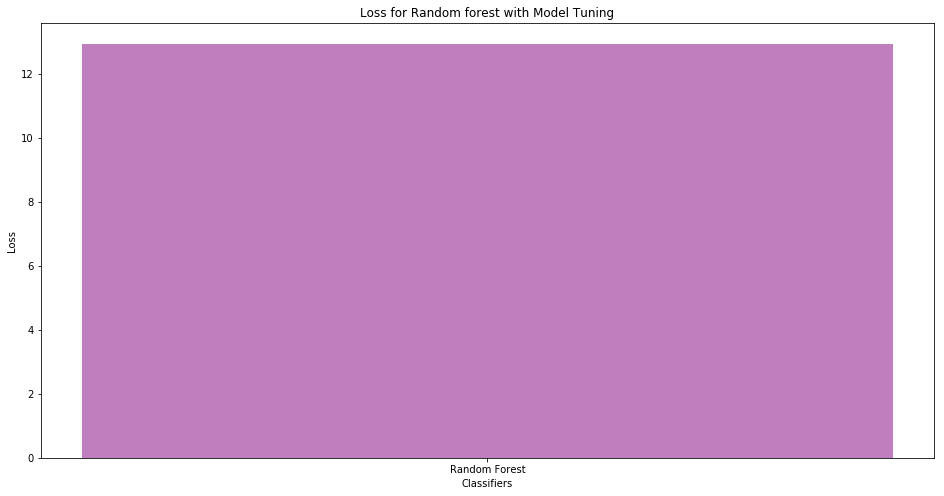

In [197]:
plt.figure(figsize=(16, 8))
x = np.arange(len(logLoss))
plt.bar(x, logLoss, alpha=0.5, color=["purple"])
plt.xticks(x, names_classifier_cv)
plt.xlabel("Classifiers")
plt.ylabel("Loss")
plt.title("Loss for Random forest with Model Tuning")
plt.show()